In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Data IO

In [8]:
df = pd.read_csv('../data/pollution.csv')

# df.to_csv('data/pollution.csv', index=False)

## Data Preview 

The data is stored in a CSV file. We will use the pandas library to load the data into a DataFrame. VSCode provides a built-in Jupyter notebook that allows us to run Python code directly in the editor, it also comes with a default data viewer that allows us to preview the data in a tabular format. It is unfortunately being deprecated, but there's a very useful extension called `data wranger` that you all have installed in your codespace instance that provdes an even richer data preview experience.

To access it, you simply have to open the bottom toolbar in VSCode and navigate to the `Jupyter` tab. There you will be able to click on the arrow next to the variable name and it will open a new tab with the data preview.

In this view, you get important summary statistics such as the number of rows, columns, and the entire dataset in a tabular view. Below the column names, you get individual column summary statistics such as the number of non-null values, the data type, and the number of unique values. You also get a histogram of the data distribution for each column. There are also options to filter the data, sort the data, and search for specific values.

## Data Manipulation

### Select Columns and Rows 

In [9]:
# Get pollution numbers for only the "oil and gas" sector and "Transport" sector
sector_ot = df[['Province', 'Year', 'Oil and gas', 'Transport']]

# Get the pollution numbers for British Columbia
bc_ot = sector_ot[sector_ot['Province'] == 'BC']

# Using indexes (not recommended)
# bc_ot = sector_ot.iloc[9]

# Get the pollution numbers for British Columbia after 2000 using slices (Only for demonstration purposes)
# bc_ot.set_index('Year', inplace=True)
# bc_ot = bc_ot.loc[2000:]

### Filter Data

In [10]:
# Filter out pollution data post 2000
post_2000 = df[df['Year'] >= 2000]

# Name the highest polluting sector for every province in every year
all = df.copy()
all['Highest_Polluting_Sector'] = df.drop(['Year', 'Province'], axis=1).idxmax(axis=1)

### Sort and Group Data

In [11]:
# Total pollution for every province sector pair 
all['Total_Pollution'] = all.drop(['Year', 'Province', 'Highest_Polluting_Sector'], axis=1).sum(axis=1)

# Get total pollution by province 
total_pollution = df.groupby('Province').sum()

# Group pollution into pre 2000 and post 2000
grouped = df.groupby(['Province', lambda x: 'Pre-2000' if df.loc[x, 'Year'] < 2000 else 'Post-2000'])
grouped = grouped.sum().unstack()

### Merge & map data

In [12]:
df_names = pd.read_csv('../data/province_names.csv')

# Two ways to map full names onto the province names
# Method 1: Merge 
full_names = df.merge(df_names, left_on='Province', right_on='Shortnam', how='left')
full_names.drop('Shortnam', axis=1, inplace=True)
full_names.rename(columns={'Region': 'Full_Name'}, inplace=True)

# Method 2: Map
df_names = df_names.set_index('Shortnam')
df_names.to_dict()
full_names = df.copy()
full_names['Full_Name'] = full_names['Province'].map(df_names.to_dict()['Region'])

### Applying functions

In [13]:
# Assume you want to change pollution values to logs for all columns except 'Year' and 'Province'
log_df = df.copy()
exclude = ['Year', 'Province']
columns_to_transform = log_df.columns.difference(exclude)
log_df[columns_to_transform] = log_df[columns_to_transform].apply(np.log)

# Getting Total polution for every sector 
sec_sum = df.copy()
sec_sum.loc['Total Sector Pollution'] = sec_sum.sum()

In [14]:
# Get a summary of pollution for every province
povince_sum = df.groupby('Province').sum().reset_index()

## Cleaning

In [15]:
# Generate Duplicates 
df_duplicated = pd.concat([df, df])
df_duplicated = df_duplicated.sample(frac=1).reset_index(drop=True)

# Generate missing values
df_missing = df.copy()
to_modify = df_missing.columns[2:]

for col in to_modify:
    rows_to_nan = np.random.choice(df_missing.index, size=int(len(df_missing)*0.1), replace=False)
    df_missing.loc[rows_to_nan, col] = np.nan


### Handling Duplicates

In [16]:
df_duplicated.drop_duplicates(subset=['Province', 'Year'], inplace=True)

### Handling Missing Values

In [17]:
# Fill missing values with the value from the previous year if it exsits or the next year if it doesn't
df_missing = df_missing.sort_values(['Province', 'Year'])
df_missing = df_missing.groupby('Province').apply(lambda group: group.fillna(method='ffill').fillna(method='bfill'))

/tmp/ipykernel_135597/769288878.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_missing = df_missing.groupby('Province').apply(lambda group: group.fillna(method='ffill').fillna(method='bfill'))
/tmp/ipykernel_135597/769288878.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_missing = df_missing.groupby('Province').apply(lambda group: group.fillna(method='ffill').fillna(method='bfill'))


## Visualization

### Matplotlib


<Axes: xlabel='Year'>

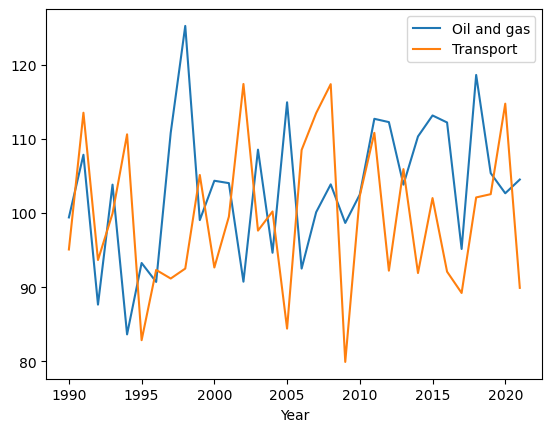

In [18]:
# Plot a line graph of pollution by sector for British Columbia over time
bc_ot.set_index('Year', inplace=True)
bc_ot.plot()

### Seaborn

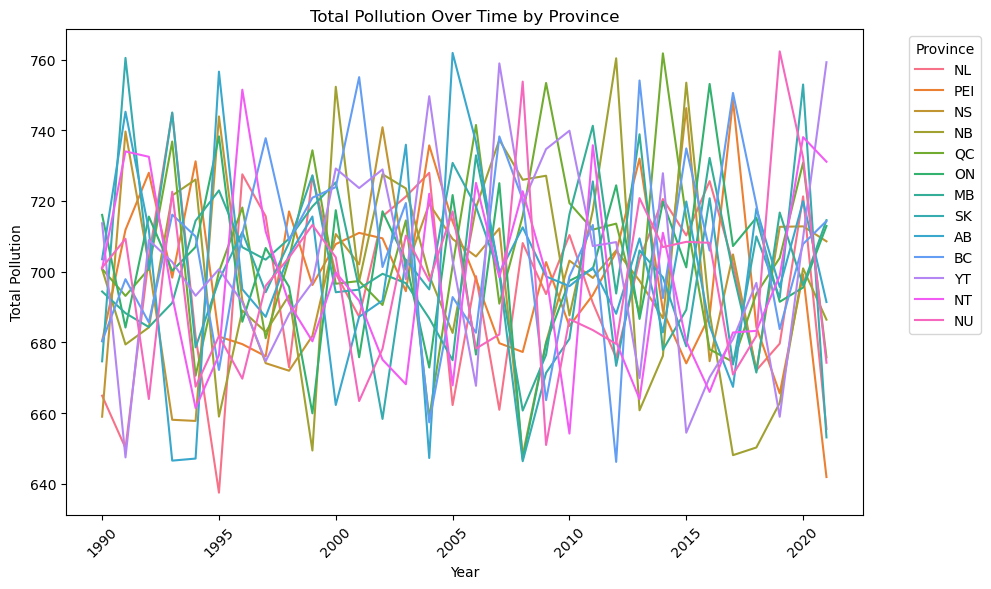

In [19]:
# Total emissions over time by province 
province_over_time = all[['Province', 'Year', 'Total_Pollution']]

# Set the figure size for the plot
plt.figure(figsize=(10, 6))  # Width, height in inches

# Plotting
sns.lineplot(data=province_over_time, x='Year', y='Total_Pollution', hue='Province')

# Enhancing the plot
plt.legend(title='Province', bbox_to_anchor=(1.05, 1), loc='upper left')  # Adjust legend position
plt.title('Total Pollution Over Time by Province')
plt.xlabel('Year')  # Optionally, customize the x-axis label
plt.ylabel('Total Pollution')  # Optionally, customize the y-axis label
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels and legend

# Display the plot
plt.show()

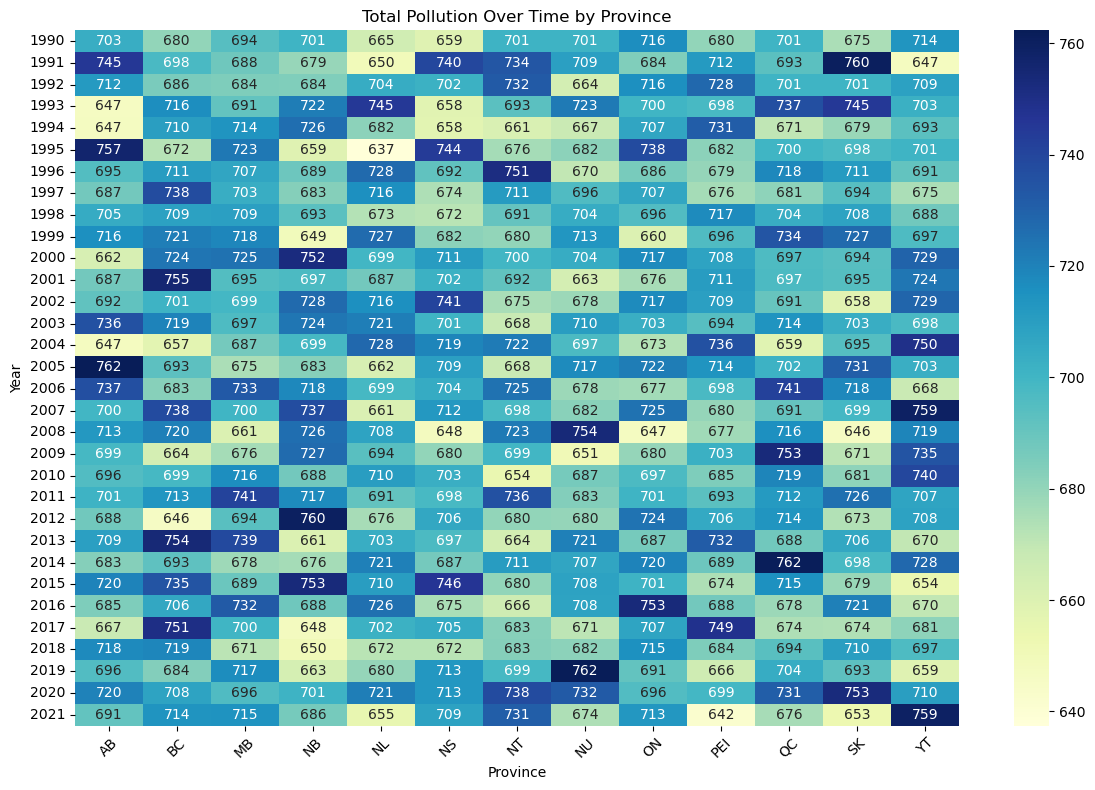

In [20]:
# Step 1: Pivot the DataFrame
pivot_table = province_over_time.pivot(index="Year", columns="Province", values="Total_Pollution")

# Step 2: Plot with Seaborn's Heatmap
plt.figure(figsize=(12, 8))  # Set the figure size
sns.heatmap(pivot_table, cmap="YlGnBu", annot=True, fmt=".0f")

# Enhancing the plot
plt.title('Total Pollution Over Time by Province')
plt.xlabel('Province')  # Adjusted for the heatmap
plt.ylabel('Year')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout

plt.show()

## Tasks

1. Plot emissions over time by sector
2. Track the total pollution of the top 5 polluters in the year 2000

<Axes: xlabel='Year'>

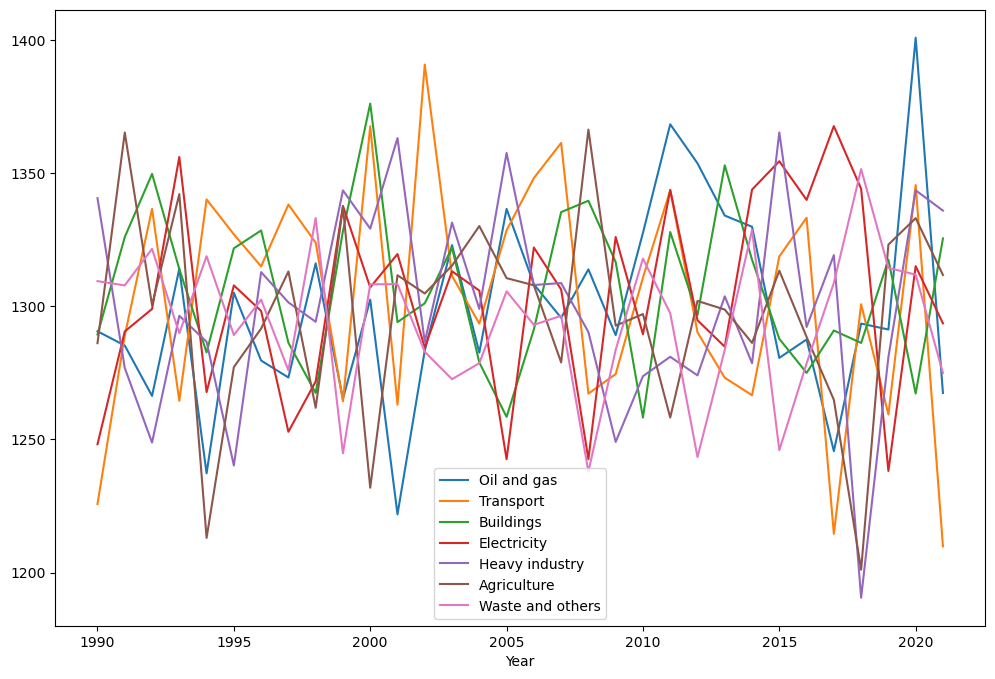

In [21]:
sector_over_time = all.copy()
sector_over_time.drop('Total_Pollution', axis=1, inplace=True)
sector_over_time.groupby('Year').sum().plot(figsize=(12, 8))

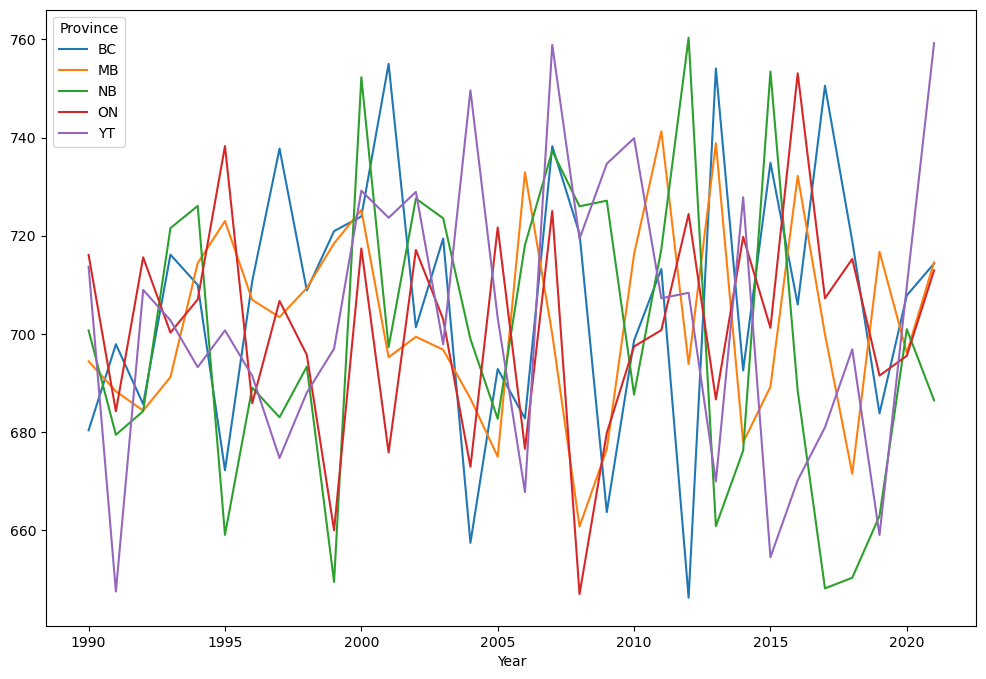

In [22]:
top_5_2000 = all[all['Year'] == 2000].nlargest(5, 'Total_Pollution')
top_5_2000 = top_5_2000['Province'].to_list()
top_5_2000 = all[all['Province'].isin(top_5_2000)]
top_5_2000 = top_5_2000.pivot(index='Year', columns='Province', values='Total_Pollution')
top_5_2000.plot(figsize=(12, 8))

plt.show()